In [1]:
import torch
import clip
from PIL import Image
import pandas as pd
import numpy as np
import plotly.express as px

In [28]:
metadata = pd.read_csv('/Users/iskomutkov/projects/medical_image_classification/ham10000/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [6]:
grouped = metadata.groupby('dx').count().reset_index()
grouped = grouped.rename(columns={'lesion_id': 'Количество изображений', 'dx': 'Диагноз'})

In [7]:
grouped

,Диагноз,Количество изображений,image_id,dx_type,age,sex,localization,dataset
0,akiec,327,327,327,327,327,327,327
1,bcc,514,514,514,514,514,514,514
2,bkl,1099,1099,1099,1089,1099,1099,1099
3,df,115,115,115,115,115,115,115
4,mel,1113,1113,1113,1111,1113,1113,1113
5,nv,6705,6705,6705,6660,6705,6705,6705
6,vasc,142,142,142,142,142,142,142


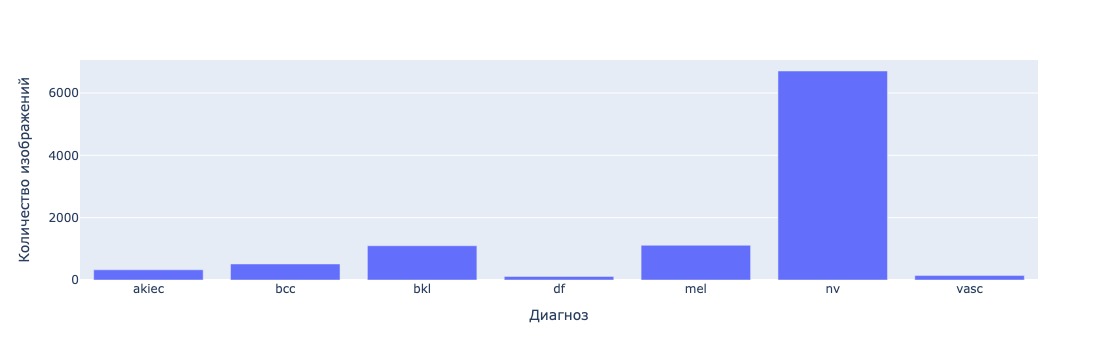

In [8]:
fig = px.bar(grouped,
             x='Диагноз',
             y='Количество изображений',
             barmode='stack')

# plot
fig.show()

In [12]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [30]:
len(metadata.image_id.unique())

10015

In [13]:
disease_dict = {"Actinic keratoses and intraepithelial carcinoma / Bowen's disease": "akiec", 
                      "basal cell carcinoma": "bcc", 
                      "benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)": "bkl",
                      "dermatofibroma": "df", "melanoma": "mel", "melanocytic nevi": "nv",
                      "vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)": "vasc"}

In [81]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("/Users/iskomutkov/projects/medical_image_classification/ham10000/HAM10000_images_part_1/ISIC_0024306.jpg")).unsqueeze(0).to(device)
diseases = ["Actinic keratoses and intraepithelial carcinoma / Bowen's disease", 
                      "basal cell carcinoma", 
                      "benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)",
                      "dermatofibroma", "melanoma", "melanocytic nevi",
                      "vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)"]
text = clip.tokenize(diseases).to(device)

In [27]:
metadata[metadata['image_id']=='ISIC_0024306']

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,vidir_molemax


In [14]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

disease_probs = dict()
for i, disease in enumerate(diseases):
    disease_probs[disease_dict[disease]] = probs[0][i]
print("Label probs:", disease_probs)

Label probs: {'akiec': 0.08069015, 'bcc': 0.46112186, 'bkl': 0.06709305, 'df': 0.005902863, 'mel': 0.11920956, 'nv': 0.076498695, 'vasc': 0.18948387}


In [15]:
disease_dict[diseases[np.argmax(probs)]]

'bcc'

In [25]:
from glob import glob
first_part = glob('/Users/iskomutkov/projects/medical_image_classification/ham10000/HAM10000_images_part_1/*')
second_part = glob('/Users/iskomutkov/projects/medical_image_classification/ham10000/HAM10000_images_part_2/*')
first_part.extend(second_part)
first_part_id = [x.split('/')[-1].split('.')[0] for x in first_part]

df_paths = pd.DataFrame({'id': first_part_id, 'path': first_part})
df_paths.head()

,id,path
0,ISIC_0026784,/Users/iskomutkov/projects/medical_image_class...
1,ISIC_0028971,/Users/iskomutkov/projects/medical_image_class...
2,ISIC_0026948,/Users/iskomutkov/projects/medical_image_class...
3,ISIC_0026790,/Users/iskomutkov/projects/medical_image_class...
4,ISIC_0028965,/Users/iskomutkov/projects/medical_image_class...


In [29]:
metadata = metadata.merge(df_paths, left_on='image_id', right_on='id').drop(columns=['id'])

In [30]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/Users/iskomutkov/projects/medical_image_class...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/Users/iskomutkov/projects/medical_image_class...


In [19]:
from tqdm.notebook import tqdm

In [31]:
batches = np.append(np.arange(0, metadata.shape[0], 64), 10015)
batches

array([    0,    64,   128,   192,   256,   320,   384,   448,   512,
         576,   640,   704,   768,   832,   896,   960,  1024,  1088,
        1152,  1216,  1280,  1344,  1408,  1472,  1536,  1600,  1664,
        1728,  1792,  1856,  1920,  1984,  2048,  2112,  2176,  2240,
        2304,  2368,  2432,  2496,  2560,  2624,  2688,  2752,  2816,
        2880,  2944,  3008,  3072,  3136,  3200,  3264,  3328,  3392,
        3456,  3520,  3584,  3648,  3712,  3776,  3840,  3904,  3968,
        4032,  4096,  4160,  4224,  4288,  4352,  4416,  4480,  4544,
        4608,  4672,  4736,  4800,  4864,  4928,  4992,  5056,  5120,
        5184,  5248,  5312,  5376,  5440,  5504,  5568,  5632,  5696,
        5760,  5824,  5888,  5952,  6016,  6080,  6144,  6208,  6272,
        6336,  6400,  6464,  6528,  6592,  6656,  6720,  6784,  6848,
        6912,  6976,  7040,  7104,  7168,  7232,  7296,  7360,  7424,
        7488,  7552,  7616,  7680,  7744,  7808,  7872,  7936,  8000,
        8064,  8128,

In [32]:
probs = []
with torch.no_grad():
    for i in tqdm(range(len(batches)-1)):
        images_batch = torch.cat([preprocess(Image.open(metadata['path'][i])).unsqueeze(0).to(device) for i in range(batches[i],
                                                                                                                    batches[i+1])])
        logits_per_image, logits_per_text = model(images_batch.to(device), text)
        probs.extend(logits_per_image.softmax(dim=-1).cpu().numpy())

  0%|          | 0/157 [00:00<?, ?it/s]

In [33]:
predicted_disease= []
for prob in probs:
    predicted_disease.append(disease_dict[diseases[np.argmax(prob)]])
metadata['predicted_disease'] = predicted_disease

In [34]:
sum(metadata['predicted_disease'] == metadata['dx'])

1357

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [40]:
gt_dx = le.fit_transform(metadata['dx'])

In [41]:
pred_dx = le.transform(metadata['predicted_disease'])

In [43]:
from sklearn.metrics import classification_report
print(classification_report(gt_dx, pred_dx))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08       327
           1       0.07      0.60      0.13       514
           2       0.18      0.15      0.16      1099
           3       0.00      0.00      0.00       115
           4       0.15      0.45      0.22      1113
           5       0.65      0.05      0.10      6705
           6       0.02      0.06      0.03       142

    accuracy                           0.14     10015
   macro avg       0.16      0.20      0.10     10015
weighted avg       0.48      0.14      0.12     10015

